<a href="https://colab.research.google.com/github/nackta/DL_time_series_learn/blob/main/deep_learning_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 단변량 시계열 예측 분석

$$ Y_t = f(Y_{t-1},Y_{t-2}, ..., Y_{t-n+1}, Y_{t-n})$$


In [ ]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std

import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

from matplotlib import pyplot

> 데이터 핸들링

In [ ]:
#1. 데이터 : 10~21.9월  물량(중량), 거래량
#2. 

In [ ]:
data = read_csv("./data/target.csv") 
hscode_list = list(data.hsCd.unique())
country_list = list(data.statCd.unique())

def load_target_data(hscode, country, target_option):
    df = pd.read_csv("./data/target.csv")
    df = df.query("hsCd == {} & statCd == '{}'".format(hscode, country))
    target = df[["year",target_option]]
    target.columns = ['ds', 'y']
    target = target.reset_index(drop=True)
    dt_index = pd.period_range(start='20100101', end='20210901', freq='M').to_timestamp()   # 날짜 데이터의 통합
    target['ds'] = dt_index
    return target

In [ ]:
data = load_target_data("8509", "US", "expDlr") # 수출금액, 미국 화장품

In [ ]:
# split a univariate dataset into train/test sets
def create_train_test(df, p):
    test_index = round(len(df)*p)
    return df[:-test_index], df[-test_index:], test_index

In [ ]:
train_df, test_df, n_test = create_train_test(data, 0.2)  # 현재는 8:2
train, test = train_df.y.values, test_df.y.values

In [ ]:
# transform list into supervised learning format 
# 시계열 형식의 데이터로 변환  

def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

> MLP

In [ ]:
# fit a model
def mlp_model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [ ]:
# forecast test
def mlp_model_forecast(train, test, n_test, model, cfg):
    predictions = list()
    # unpack config
    n_input, _, _, _ = config
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(n_test):
        # fit model and make forecast for history
        yhat = model.predict(array(history[-n_input:]).reshape(1, n_input), verbose=0)
        # store forecast in list of predictions
        predictions.append(yhat.mean())
        # add actual observation to history for the next loop
        history.append(test[i])
        
    return predictions, history

In [ ]:
config = [24, 500, 100, 100] # n_input, n_nodes, n_epochs, n_batch
mlp_model = mlp_model_fit(train, config)
prediction, history = mlp_model_forecast(train, test, n_test, mlp_model, config)

0.1485803655471707


<AxesSubplot:xlabel='ds'>

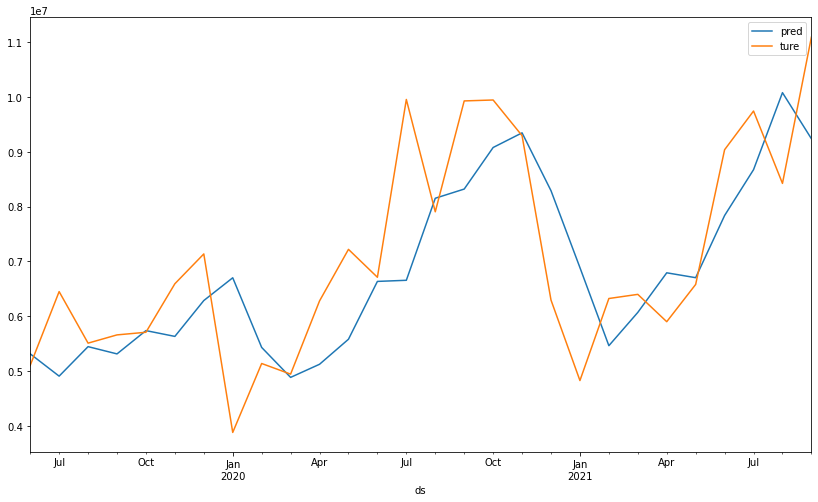

In [ ]:
print(mean_absolute_percentage_error(test, array(prediction)))
DataFrame({'pred' : prediction, 'ture' : test}, index = test_df.ds).plot(figsize = (14,8))

> CNN

In [ ]:
# fit a model
def cnn_model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(n_filters, n_kernel, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [ ]:
# forecast test
def cnn_model_forecast(train, test, n_test, model, cfg):
    predictions = list()
    # unpack config
    n_input, _, _, _, _ = config
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(n_test):
        # fit model and make forecast for history
        yhat = model.predict(array(history[-n_input:]).reshape(1, n_input, 1), verbose=0)
        # store forecast in list of predictions
        predictions.append(yhat.mean())
        # add actual observation to history for the next loop
        history.append(test[i])
        
    return predictions, history

In [ ]:
config = [24, 256, 3, 100, 100] # n_input, n_filters, n_kernel, n_epochs, n_batch
cnn_model = cnn_model_fit(train, config)
prediction, history = cnn_model_forecast(train, test, n_test, cnn_model, config)

0.1772992862412912


<AxesSubplot:xlabel='ds'>

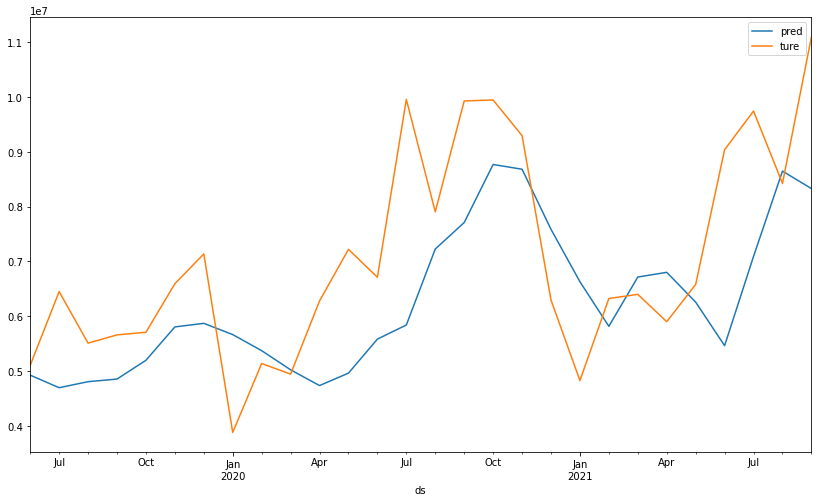

In [ ]:
print(mean_absolute_percentage_error(test, array(prediction)))  # rMSE, R2, .. MAE
DataFrame({'pred' : prediction, 'ture' : test}, index = test_df.ds).plot(figsize = (14,8))

> LSTM

In [ ]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def lstm_model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [ ]:
# forecast test
def lstm_model_forecast(train, test, n_test, model, cfg):
    predictions = list()
    # unpack config
    n_input, _, _, _, n_diff = config
    # seed history with training dataset
    history = [x for x in train]
    
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
        
    # step over each time-step in the test set
    for i in range(n_test):
        # fit model and make forecast for history
        yhat = model.predict(array(history[-n_input:]).reshape(1, n_input, 1), verbose=0)
        # store forecast in list of predictions
        predictions.append(yhat.mean())
        # add actual observation to history for the next loop
        history.append(test[i])
        
    return predictions, history

In [ ]:
config = [24, 50, 100, 100, 0] # n_input, n_nodes, n_epochs, n_batch, n_diff
lstm_model = lstm_model_fit(train, config)
prediction, history = lstm_model_forecast(train, test, n_test, lstm_model, config)

0.12671876093680026


<AxesSubplot:xlabel='ds'>

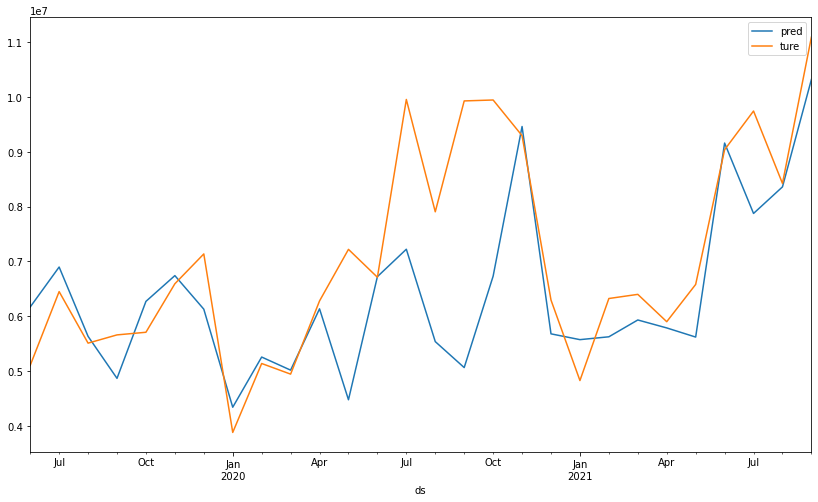

In [ ]:
# true 값이 0이면. 예측과정에 따른 오류가 있다. 

print(mean_absolute_percentage_error(test, array(prediction)))
DataFrame({'pred' : prediction, 'ture' : test}, index = test_df.ds).plot(figsize = (14,8))

> CNN_LSTM

In [ ]:
# fit a model
def cnnlstm_model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [ ]:
# forecast test
def cnnlstm_model_forecast(train, test, n_test, model, cfg):
    predictions = list()
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(n_test):
        # fit model and make forecast for history
        yhat = model.predict(array(history[-n_input:]).reshape((1, n_seq, n_steps, 1)), verbose=0)
        # store forecast in list of predictions
        predictions.append(yhat.mean())
        # add actual observation to history for the next loop
        history.append(test[i])
        
    return predictions, history

In [ ]:
config = [3, 12, 64, 3, 100, 200, 100] # n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch
cnn_lstm_model = cnnlstm_model_fit(train, config)
prediction, history = cnnlstm_model_forecast(train, test, n_test, cnn_lstm_model, config)

0.22095097583417264


<AxesSubplot:xlabel='ds'>

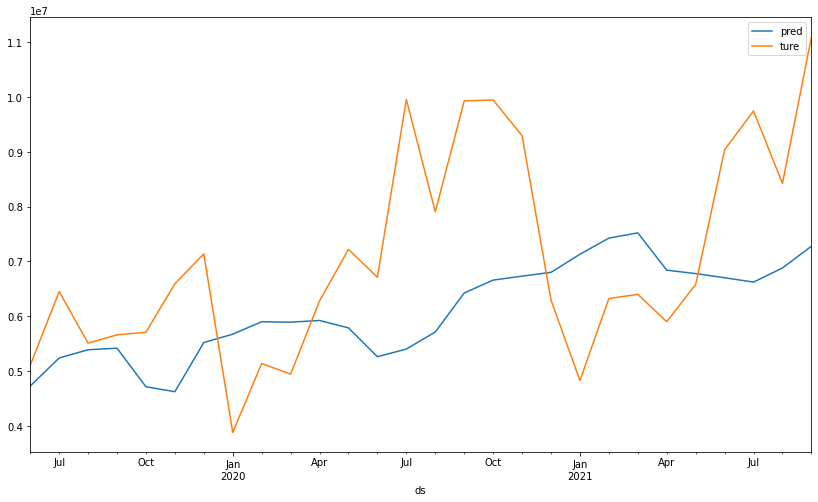

In [ ]:
print(mean_absolute_percentage_error(test, array(prediction)))
DataFrame({'pred' : prediction, 'ture' : test}, index = test_df.ds).plot(figsize = (14,8))

> CONVLSTM

In [ ]:
# fit a model
def convlstm_model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(n_filters, (1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [ ]:
# forecast test
def convlstm_model_forecast(train, test, n_test, model, cfg):
    predictions = list()
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(n_test):
        # fit model and make forecast for history
        yhat = model.predict(array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1)), verbose=0)
        # store forecast in list of predictions
        predictions.append(yhat.mean())
        # add actual observation to history for the next loop
        history.append(test[i])
        
    return predictions, history

In [ ]:
config = [3, 12, 256, 3, 200, 200, 100]
convlstm_model = convlstm_model_fit(train, config)
prediction, history = convlstm_model_forecast(train, test, n_test, convlstm_model, config)

0.2685719577265767


<AxesSubplot:xlabel='ds'>

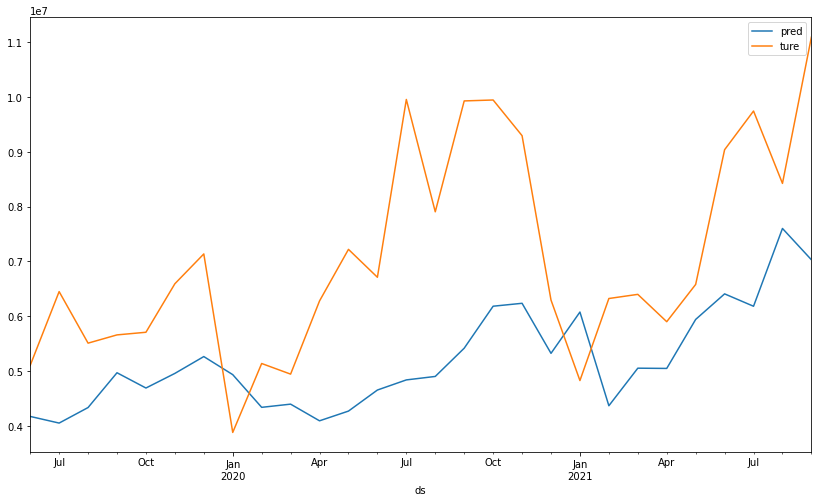

In [ ]:
print(mean_absolute_percentage_error(test, array(prediction)))
DataFrame({'pred' : prediction, 'ture' : test}, index = test_df.ds).plot(figsize = (14,8))

In [ ]:
def make_configs(a, b):
    
    configs = list()
    for i in a:
        for j in b:
            cfg = [i,j]
            configs.append(cfg)
            
    return configs

configs_list = make_configs(country_list, hscode_list)
len(configs_list)

129

In [ ]:
# 시계열 데이터로 변환시 0이 연속이면 해당 데이터를 삭제   { X. X 0, 0 , X, X }
error_configs = []

for country, hscode in configs_list:
    try:
        df = load_target_data(hscode, country, "expDlr")
        
        if 0 in list(df.y.diff().unique()):
            error_configs.append([country, hscode])
            
    except:
        error_configs.append([country, hscode])
len(error_configs)

34

In [ ]:
for i in error_configs:
    configs_list.remove(i)
len(configs_list)

95

In [ ]:
def mlp_model_metric_configs(configs_list, config):
    
    mape_list = []

    for country, hscode in configs_list:
        data = load_target_data(hscode, country, "expDlr")
        train_df, test_df, n_test = create_train_test(data, 0.2)
        train, test = train_df.y.values, test_df.y.values

        model = mlp_model_fit(train, config)
        prediction, history = mlp_model_forecast(train, test, n_test, model, config)
        mape = mean_absolute_percentage_error(test, array(prediction))

        mape_list.append([country, hscode, mape])

    return pd.DataFrame(data = mape_list, columns = ["country", "hscode", "mape"])

In [ ]:
def cnn_model_metric_configs(configs_list, config):
    
    mape_list = []

    for country, hscode in configs_list:
        data = load_target_data(hscode, country, "expDlr")
        train_df, test_df, n_test = create_train_test(data, 0.2)
        train, test = train_df.y.values, test_df.y.values

        model = cnn_model_fit(train, config)
        prediction, history = cnn_model_forecast(train, test, n_test, model, config)
        mape = mean_absolute_percentage_error(test, array(prediction))

        mape_list.append([country, hscode, mape])

    return pd.DataFrame(data = mape_list, columns = ["country", "hscode", "mape"])

In [ ]:
def lstm_model_metric_configs(configs_list, config):
    
    mape_list = []

    for country, hscode in configs_list:
        data = load_target_data(hscode, country, "expDlr")
        train_df, test_df, n_test = create_train_test(data, 0.2)
        train, test = train_df.y.values, test_df.y.values

        model = lstm_model_fit(train, config)
        prediction, history = lstm_model_forecast(train, test, n_test, model, config)
        try:
            mape = mean_absolute_percentage_error(test, array(prediction))
        except:
            mape = 1

        mape_list.append([country, hscode, mape])

    return pd.DataFrame(data = mape_list, columns = ["country", "hscode", "mape"])

In [ ]:
def cnnlstm_model_metric_configs(configs_list, config):
    
    mape_list = []

    for country, hscode in configs_list:
        data = load_target_data(hscode, country, "expDlr")
        train_df, test_df, n_test = create_train_test(data, 0.2)
        train, test = train_df.y.values, test_df.y.values

        model = cnnlstm_model_fit(train, config)
        prediction, history = cnnlstm_model_forecast(train, test, n_test, model, config)
        mape = mean_absolute_percentage_error(test, array(prediction))

        mape_list.append([country, hscode, mape])

    return pd.DataFrame(data = mape_list, columns = ["country", "hscode", "mape"])

In [ ]:
def convlstm_model_metric_configs(configs_list, config):
    
    mape_list = []

    for country, hscode in configs_list:
        data = load_target_data(hscode, country, "expDlr")
        train_df, test_df, n_test = create_train_test(data, 0.2)
        train, test = train_df.y.values, test_df.y.values

        model = convlstm_model_fit(train, config)
        prediction, history = convlstm_model_forecast(train, test, n_test, model, config)
        
        try:
            mape = mean_absolute_percentage_error(test, array(prediction))
        except:
            mape = 1

        mape_list.append([country, hscode, mape])

    return pd.DataFrame(data = mape_list, columns = ["country", "hscode", "mape"])

In [ ]:
config = [24, 500, 100, 100]
mlp_metric = mlp_model_metric_configs(configs_list, config)

In [ ]:
config = [24, 256, 3, 100, 100]
cnn_metric = cnn_model_metric_configs(configs_list, config)

In [ ]:
config = [24, 50, 100, 100, 0]
lstm_metric = lstm_model_metric_configs(configs_list, config)

In [ ]:
config = [3, 12, 64, 3, 100, 200, 100]
cnnlstm_metric = cnnlstm_model_metric_configs(configs_list, config)

In [ ]:
config = [3, 12, 256, 3, 200, 200, 100]
convlstm_metric = convlstm_model_metric_configs(configs_list, config)

In [ ]:
deep_learning_metric = pd.concat([mlp_metric[["country", "hscode"]] ,mlp_metric.mape*100, cnn_metric.mape*100, lstm_metric.mape*100, cnnlstm_metric.mape*100, convlstm_metric.mape*100], axis = 1)
pd.options.display.float_format = '{:.3f}'.format
deep_learning_metric

,country,hscode,mape,mape,mape,mape,mape
0,CN,3304,13.075,13.003,18.489,13.264,100.000
1,CN,3305,25.817,27.135,36.865,28.127,28.635
2,CN,3306,32.166,40.366,28.345,42.071,43.297
3,CN,3307,19.832,27.515,41.149,22.214,103.249
4,CN,6102,55.617,48.748,101.610,61.365,53.321
...,...,...,...,...,...,...,...
90,VN,8523,59.625,68.536,71.646,97.091,58.993
91,VN,8525,178.633,209.614,69.018,188.620,62.808
92,VN,8528,65.806,106.125,54.115,97.359,55.612
93,VN,8539,25.334,26.749,37.561,28.577,33.577


In [ ]:
deep_learning_metric.columns = ["country", "hscode", "mlp", "cnn", "lstm", "cnnlstm", "convlstm"]
#table = deep_learning_metric.query("mlp < 20 | cnn < 20 | lstm < 20 | cnn < 20 | cnnlstm < 20 | convlstm < 20")
#table.to_csv("table.csv")
deep_learning_metric.to_csv("result_all.csv")